In [1]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

from src.processing.constants import *
from src.processing.utils import list_files
from src.processing.txt_loading import txt_to_list
from src.processing.radial import radial_select, order_coords, create_radius_select_stack, find_period_radial_select
from src.processing.constants import BUCKLING_PATH, EDGE_TRACKING_PATH
import pandas as pd

## 1. Setup

In [2]:
image_name = '200920_biolight_nobg_nooutliers_despeckle_enhance.tif'
slice = 120

In [3]:
image_path = BUCKLING_PATH / image_name
assert image_path.exists()

In [4]:
image = imread(str(image_path))[slice]

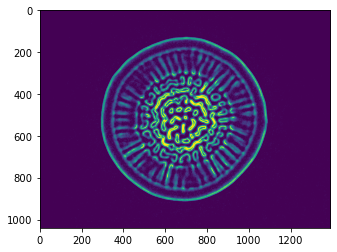

In [5]:
plt.imshow(image)

## 2. Analysis

In [6]:
height, width = np.shape(image)

In [7]:
timestamps_b, radii_b, x_center_b, y_center_b = txt_to_list(str(EDGE_TRACKING_PATH/'200920_biolight_fitted_circle_position_data.txt'))
x_center, y_center = x_center_b[slice], y_center_b[slice]
center_fitted = (x_center, y_center)

In [8]:
#(disk_y_coords, disk_x_coords, disk_values) = radial_select(image, center_fitted, 100, 0.5)
disk_x_y_vals = np.array(radial_select(image, center_fitted, 400, 0.5))

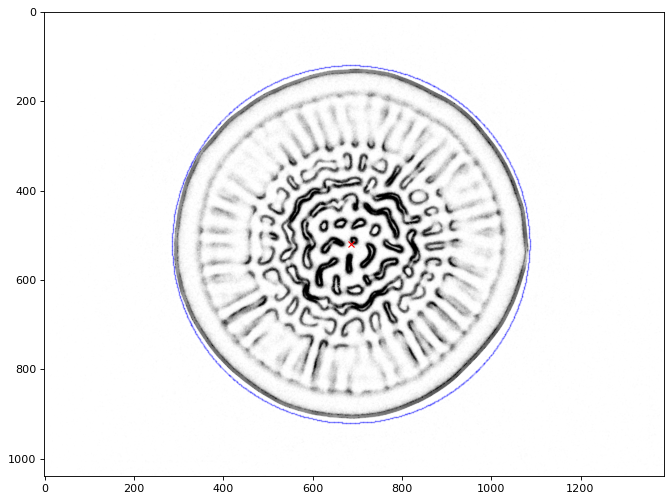

In [9]:
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(image, cmap = 'Greys')
#plt.plot(x_centre, y_centre, 'xr')
plt.plot(disk_x_y_vals[1], disk_x_y_vals[0], 'bo',markersize = 0.1)
plt.plot(x_center, y_center, 'xr')
plt.show()

In [99]:
stack = create_radius_select_stack(image, center_fitted, 300, 0.5)
data = stack[2]

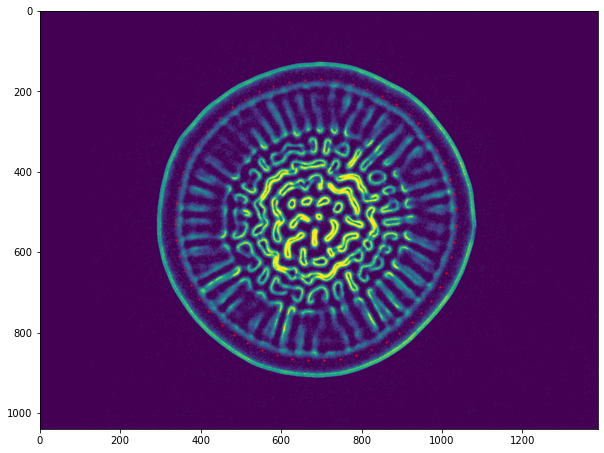

In [95]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.imshow(image)
ax.plot(stack[0][::40], stack[1][::40], 'ro', ms = 1)
ax.set_aspect('equal')
plt.show()

In [96]:
from scipy.signal import find_peaks

In [97]:
def find_period_radial_select(stack, plot=False):
    data = stack[2]
    auto_correlation = np.correlate(data, data, mode='same')
    lags = np.arange(-len(auto_correlation)/2, len(auto_correlation)/2)

    peaks, _ = find_peaks(auto_correlation, height=0)
    second_maximum = np.sort(auto_correlation[peaks])[-2]
    index = np.where(auto_correlation == second_maximum)[0]
    period = (lags[index[1]]/len(data))*360

    if plot == True:
        plt.figure(figsize=(20, 10), dpi=80)
        plt.plot(lags, auto_correlation)
        plt.plot(lags[peaks], auto_correlation[peaks], "x")
        plt.show()
    return period


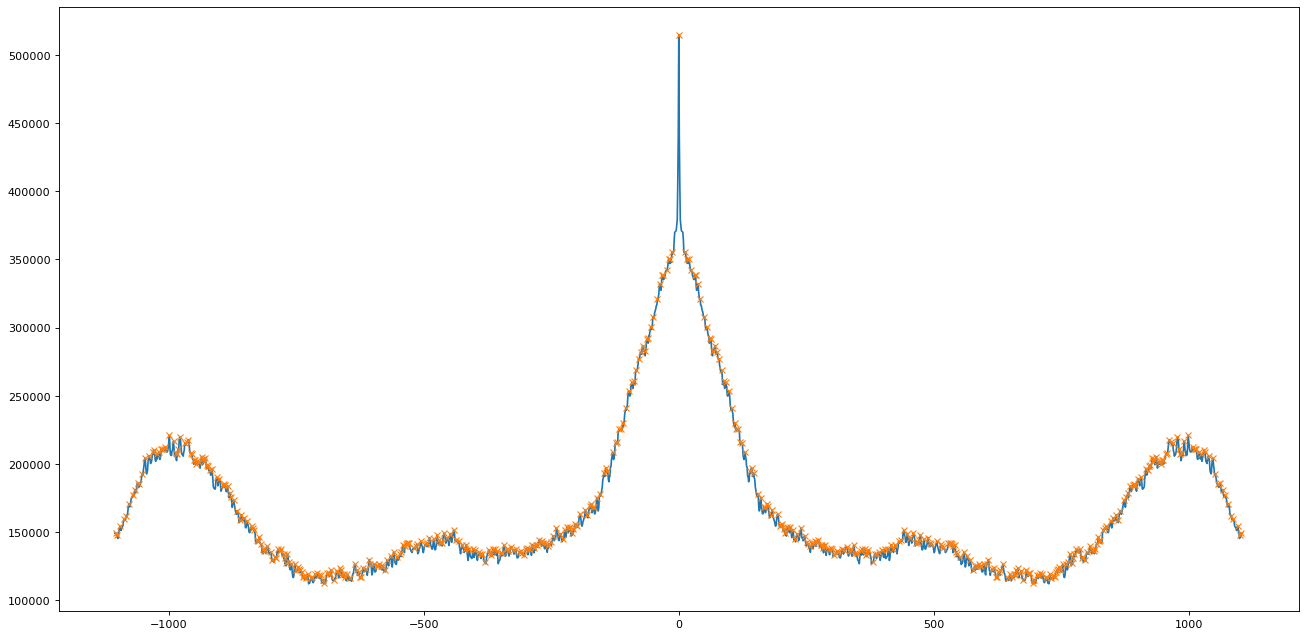

2.115732368896926

In [98]:
find_period_radial_select(stack, True)

Text(0, 0.5, 'Period (degrees)')

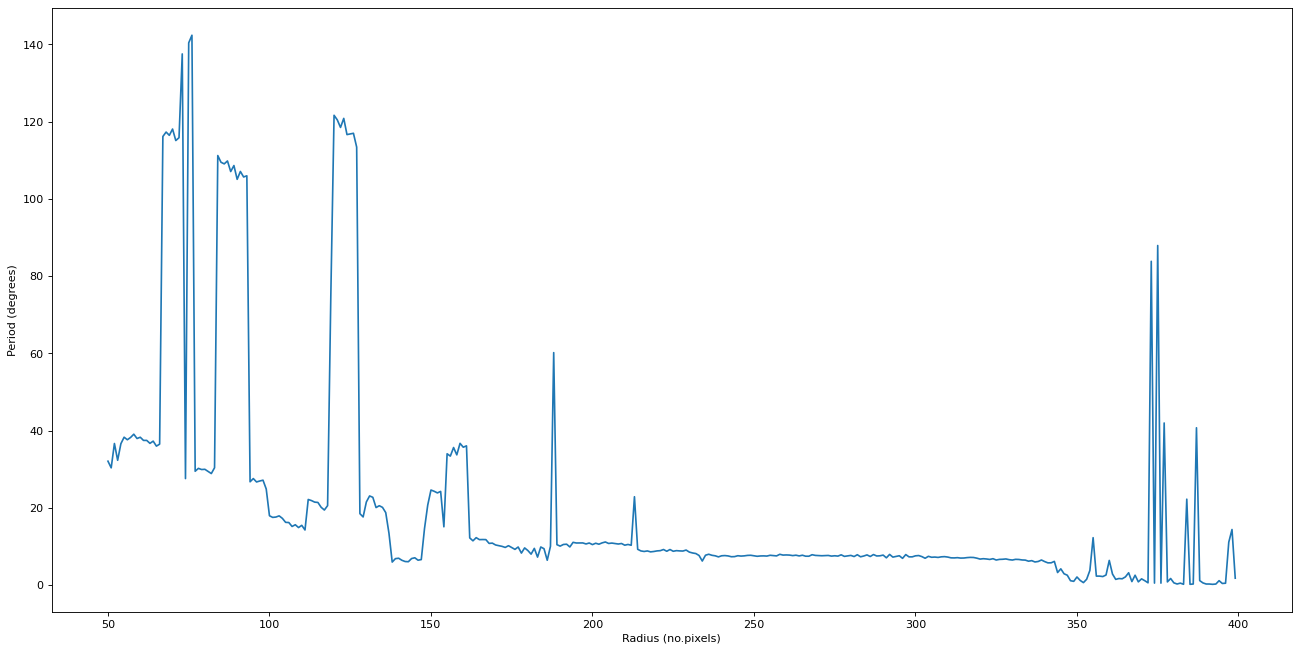

In [93]:
period  = []
radii = []
for r in range(50,400):
    radii.append(r)
    stack = create_radius_select_stack(image, center_fitted,  r, 0.5)
    period.append(find_period_radial_select(stack))

plt.figure(figsize=(20, 10), dpi=80)
plt.plot(radii, period)
plt.xlabel('Radius (no.pixels)')
plt.ylabel('Period (degrees)')

36.5


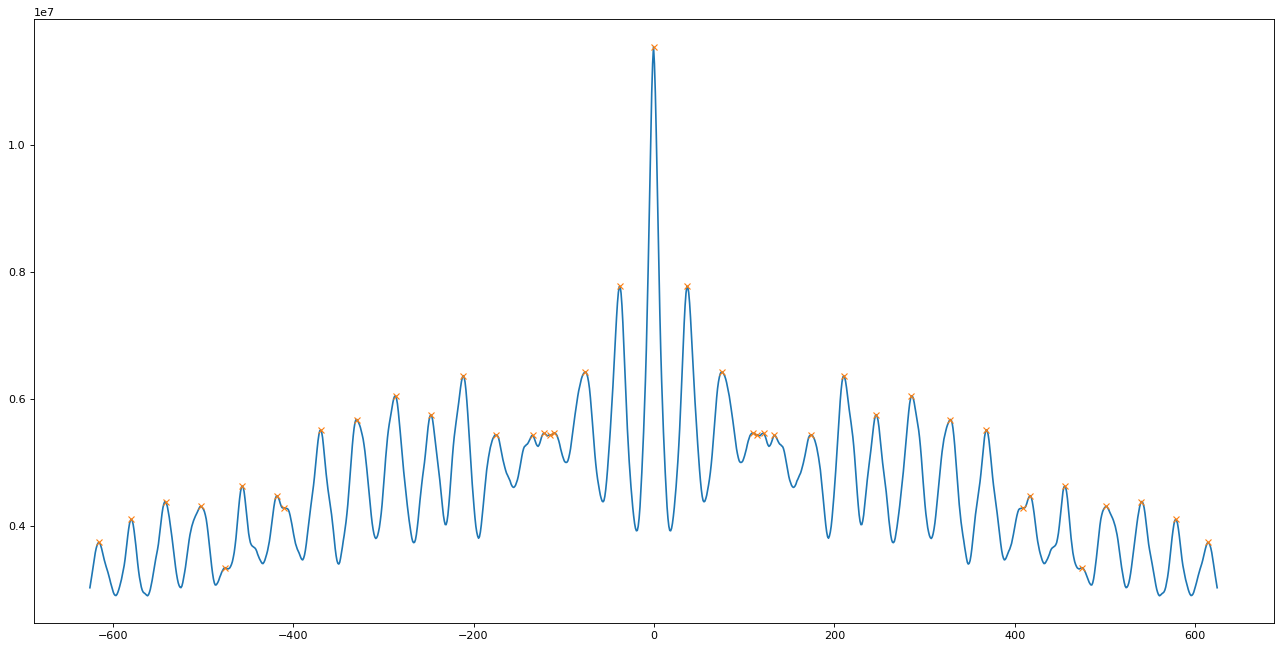

In [ ]:
plt.figure(figsize=(20, 10), dpi=80)
peaks, _ = find_peaks(auto_correlation, height=0)
plt.plot(lags, auto_correlation)
plt.plot(lags[peaks], auto_correlation[peaks], "x")
second_maximum = np.sort(auto_correlation[peaks])[-2]
index = np.where(auto_correlation == second_maximum)[0]
period = lags[index[1]]
print(period)
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

The Autocorreleation plot for the data is:


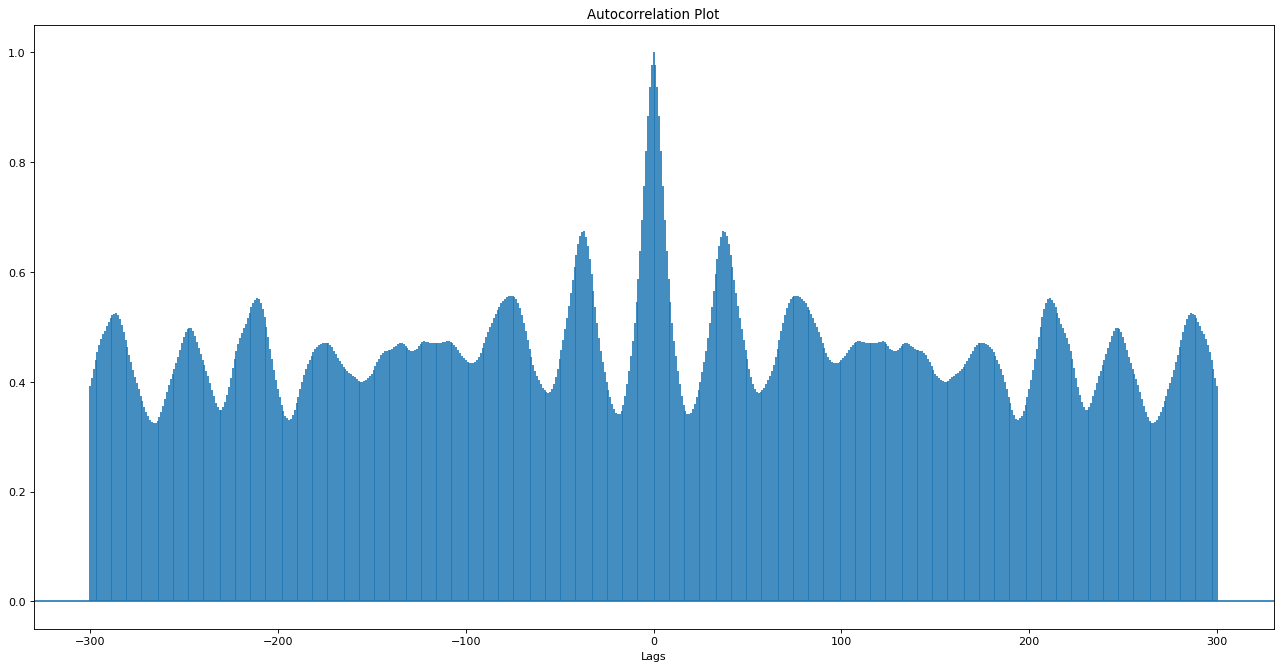

In [ ]:
plt.figure(figsize=(20, 10), dpi=80)
plt.title("Autocorrelation Plot")
plt.xlabel("Lags")
 
# Plotting the Autocorreleation plot.
plt.acorr(data, maxlags = 300)
 
# Displaying the plot.
print("The Autocorreleation plot for the data is:")
#plt.grid(True)
 
plt.show()

In [ ]:
print(len(data))
panda_data = pd.Series(data)
print(len(panda_data))
panda_data.autocorr(750)

762
762


0.8627801959061309

In [ ]:
auto_data = pd.Series([panda_data.autocorr(i) for i in range(0,data.shape[0]-1)], index=range(0,data.shape[0]-1))

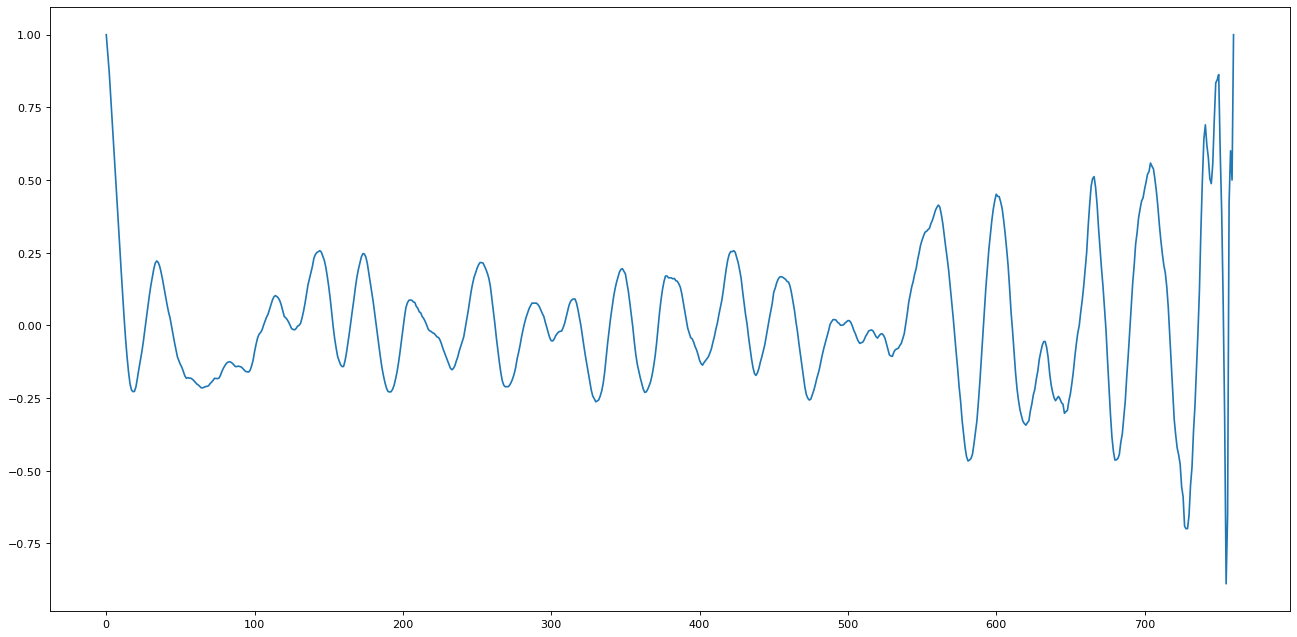

In [ ]:
plt.figure(figsize=(20, 10), dpi=80)
plt.plot(auto_data)